## Imports

In [272]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from ipywidgets import interact, fixed
from scipy.ndimage import gaussian_filter1d
import warnings
from tqdm import tqdm
from collections import defaultdict

In [246]:
warnings.filterwarnings('ignore')

## Constants

In [261]:
TRENDS_PATH = "/mlodata1/prakhar/twitter_covid_insights/insights_All/trends.pkl"
TRENDS_RAW_PATH = "/mlodata1/prakhar/twitter_covid_insights/insights_All/trends_raw.pkl"
TOPICS_PATH = "/mlodata1/prakhar/twitter_covid_insights/insights_All/topics.pkl"
TWEETS_PIPED_PATH = "/mlodata1/prakhar/all_available_tweets_piped"
CLUSTERED_TWEETS_PATH = "/mlodata1/raileanu/clustered_sampled_tweets"

##  Most common topics

In [253]:
def most_common_topics_per_day(trends, dates, topic_labels, day, n=50):
    day_counts = {k: v[day] for k, v in trends.items()}
    day_counts = dict(sorted(day_counts.items(), key=lambda item: item[1], reverse=True))
    day_counts = {topic_labels[int(k)]: day_counts[k] / list(day_counts.values())[0] for k in list(day_counts)[:n]}
    
    fig, ax = plt.subplots(1, 1)
    ax.set_xticklabels(list(day_counts.keys()), rotation=45, ha='right')
    sns.barplot(x=list(day_counts.keys()), y=list(day_counts.values()), palette="rocket", ax=ax)
    ax.set_xlabel('Topic')
    ax.set_ylabel(f'Frequency')
    ax.set_title(f'Most common topics in {dates[day]}')

In [254]:
def get_dates():
    file_names = os.listdir(TWEETS_PIPED_PATH)
    return [name.replace('parsed_', '').replace('.parquet', '') for name in file_names]

In [255]:
trends = pkl.load(open(TRENDS_PATH, 'rb'))[0]
trends = {k: v for k, v in trends.items() if not k.startswith('Pos') and not k.startswith('Neg')}
topics = pkl.load(open(TOPICS_PATH, 'rb'))[0]
topic_labels = {k: v[0] for k, v in topics.items()}
dates = get_dates()

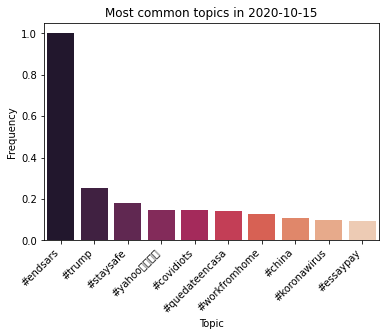

In [256]:
most_common_topics_per_day(trends, dates, topic_labels, 350, n=10)

In [257]:
interact(most_common_topics_per_day, trends=fixed(trends),
         dates=fixed(dates), topic_labels=fixed(topic_labels),
         n=fixed(10), day=(92, len(dates) - 1, 1));

interactive(children=(IntSlider(value=388, description='day', max=684, min=92), Output()), _dom_classes=('widg…

## Tokyo 2020 Analysis

In [262]:
topics = pkl.load(open(TOPICS_PATH, 'rb'))[0]
daily_occ_per_topic = pkl.load(open(TRENDS_RAW_PATH, 'rb'))[0]
tot_occ_per_topic = {}

# Get the most popular topics by number of occurrences
for topic in daily_occ_per_topic:
    if not topic.startswith('Pos-') and not topic.startswith('Neg-'):
        tot_occ_per_topic[topic] = np.sum(np.array(daily_occ_per_topic[topic]))
    
tot_occ_per_topic = dict(sorted(tot_occ_per_topic.items(), key=lambda item: -item[1]))
most_cited = [int(x) for x in list(tot_occ_per_topic.keys())[:10]]
print(f"Most cited topics: {most_cited}")

Most cited topics: [71, 39, 29, 141, 19, 80, 117, 60, 211, 75]


In [273]:
# Label the top 10 topics with the first hashtag and create a dict with their occurrences
labels = {}
most_cited_daily_occ = {}
for topic in most_cited:
    labels[topic] = topics[topic][0]
    print(topics[topic])
    most_cited_daily_occ[topic] = daily_occ_per_topic[str(topic)]

['#vaccine' '#covidvaccine' '#vaccines' '#vaccinated' '#covid19vaccine'
 '#moderna' '#vaccinations' '#pfizervaccine' '#covidvaccines'
 '#pfizerbiontech' '#johnsonandjohnson' '#covid19vaccines'
 '#modernavaccine' '#astrazenecavaccine' '#boostershots'
 '#oxfordastrazeneca' '#vaccinehesitancy' '#pfizercovidvaccine'
 '#johnsonandjohnsonvaccine' '#boostershot' '#phizer']
['#china' '#wuhan' '#chinavirus' '#wuhanvirus' '#ccp' '#chinesevirus'
 '#wuhancoronavirus' '#ccpvirus' '#chinaliedpeopledied' '#chinese'
 '#ccpchina' '#xijinping' '#chinaliedandpeopledied' '#chinamustpay'
 '#wuhanflu' '#chinazi' '#ccpliedpeopledied' '#makechinapay' '#wuhanlab'
 '#kungflu' '#chinajoe' '#china_is_terrorist' '#beijingbiden'
 '#chinesecommunistparty' '#chinajoebiden' '#communistchina'
 '#bidencrimefamilly' '#xitler' '#bidencrimefamiily']
['#trump' '#biden' '#america' '#gop' '#donaldtrump' '#democrats'
 '#joebiden' '#americans' '#republicans' '#potus' '#scotus' '#american'
 '#republican' '#democrat' '#kentucky' 

In [274]:
# Re-labeling for better visualization
new_labels = {71: 'COVID-19 Vaccines', 39: 'COVID-19 China', 29: 'American elections', 
              141: 'Tokyo Olympics', 19: 'COVID-19 Outbreak', 80: 'Stay safe', 117: 'Daily motivation',
              60: 'Pro vax', 211: 'World news', 75: 'Work from home'}

In [275]:
# Appending nan values for the dates that are missing
for topic in most_cited_daily_occ:
    new_values = []
    index = 0
    for i, d in enumerate(pd.date_range('2019-10-01', '2021-09-30')):
        date = d.strftime('%Y-%m-%d')
        if not os.path.isfile(os.path.join(TWEETS_PIPED_PATH, 'parsed_' + date + '.parquet')):
            new_values.append(np.nan)
        elif most_cited_daily_occ[topic][index] < 500:
            new_values.append(np.nan)
            index+=1
        else: 
            new_values.append(most_cited_daily_occ[topic][index])
            index += 1
    most_cited_daily_occ[topic] = new_values

In [276]:
# Linearly interpolating missing values and smoothing
for topic in most_cited_daily_occ:
    most_cited_daily_occ[topic] = pd.Series(most_cited_daily_occ[topic]).interpolate().tolist()
    most_cited_daily_occ[topic] = gaussian_filter1d(most_cited_daily_occ[topic], 2)

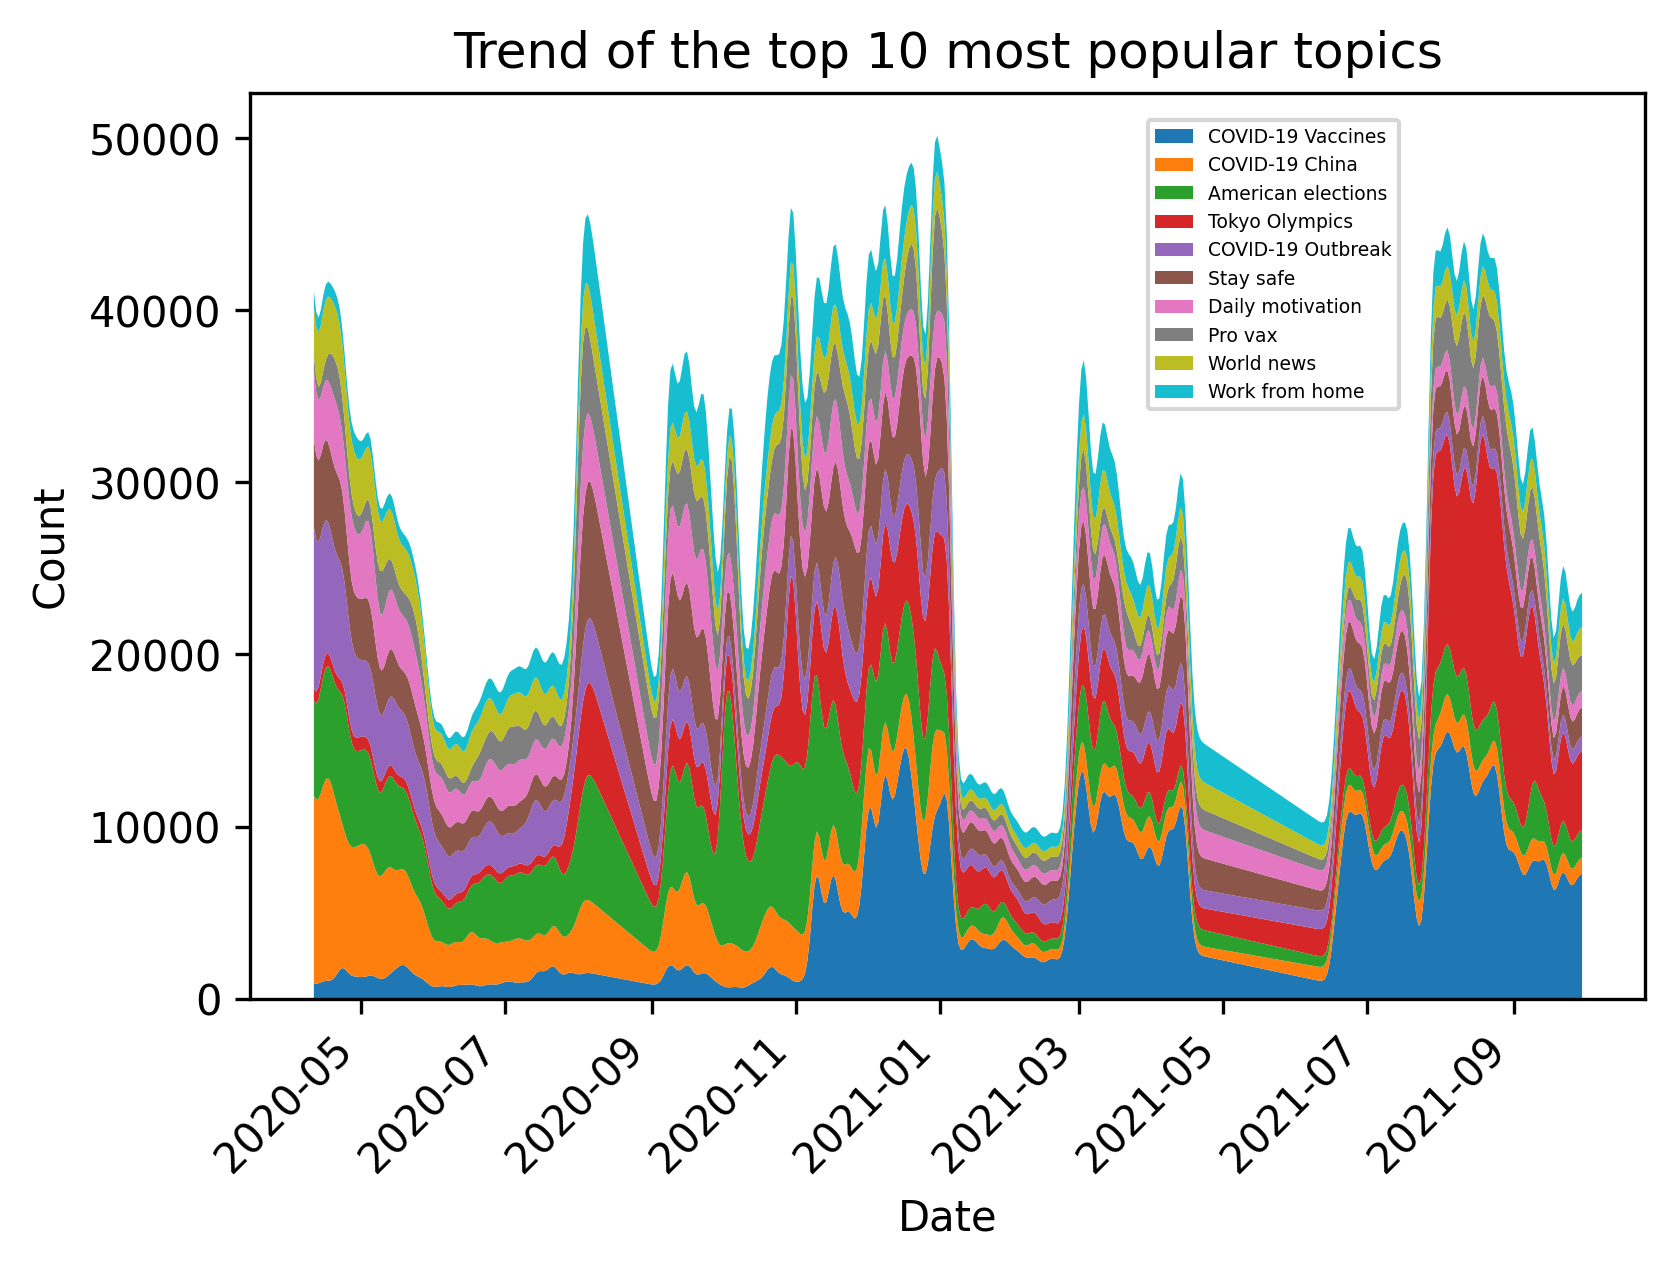

In [277]:
# Stack plot
plt.stackplot(pd.date_range('2019-10-01', '2021-09-30'), 
              most_cited_daily_occ[71], 
              most_cited_daily_occ[39], 
              most_cited_daily_occ[29],
              most_cited_daily_occ[141],
              most_cited_daily_occ[19],
              most_cited_daily_occ[80],
              most_cited_daily_occ[117],
              most_cited_daily_occ[60],
              most_cited_daily_occ[211],
              most_cited_daily_occ[75],
              labels=list(new_labels.values()))
plt.legend(fontsize = 4.5, bbox_to_anchor=(0.83, 0.98))
plt.xticks(rotation=45, ha="right")
plt.title('Trend of the top 10 most popular topics')
plt.ylabel('Count')
plt.xlabel('Date');

In [279]:
# checking if COVID trend in japan is correlated with Tokyo Olympics topic
epi_data = pd.read_csv('/mlodata1/raileanu/Topics_Visualization/paper_code/Data/global_countries.csv')
japan_data = epi_data[epi_data['name'] == 'Japan']

In [280]:
japan_data = japan_data[(japan_data['date'] >= '2020-04-01') & (japan_data['date'] <= '2021-09-30')]
olympics_trend = most_cited_daily_occ[141][184:]

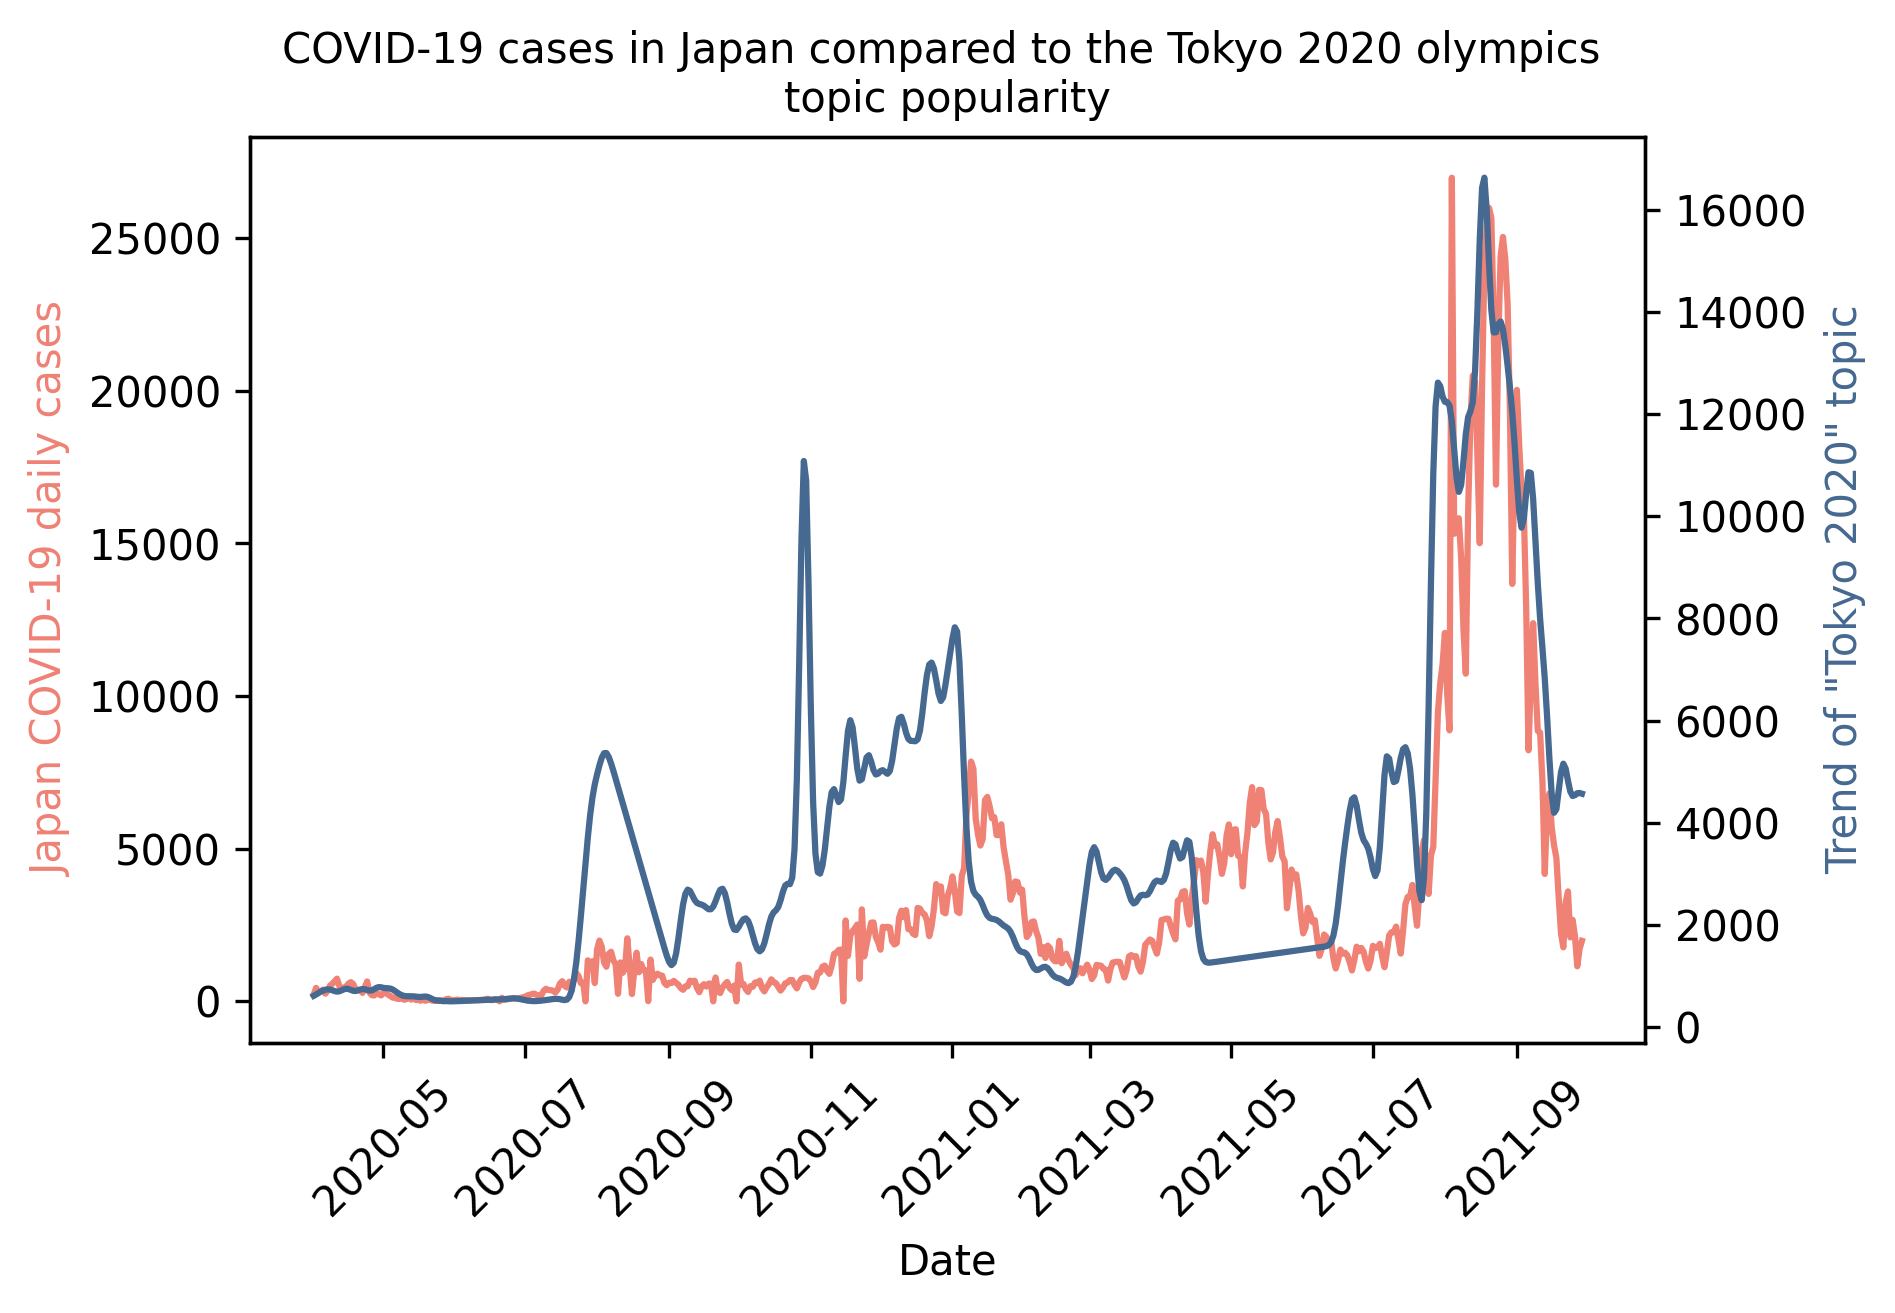

In [281]:
# Plot the Japan-news topic in relation to the epi data
fig, ax = plt.subplots()

ax.plot(pd.date_range('2020-04-01', '2021-09-29'), japan_data['new_cases'], color="#EF8275")
ax.xaxis.set_tick_params(rotation=45)

ax.set_xlabel("Date",fontsize=10)
ax.set_ylabel("Japan COVID-19 daily cases",color="#EF8275",fontsize=10)
ax2=ax.twinx()

ax2.plot(pd.date_range('2020-04-01', '2021-09-29'), olympics_trend,color="#456990")
ax2.set_ylabel("Trend of \"Tokyo 2020\" topic",color="#456990",fontsize=10);
plt.title("COVID-19 cases in Japan compared to the Tokyo 2020 olympics \ntopic popularity", fontsize = 10);